In [1]:
import heeps
from heeps.wavefront.get_array import show_wf, get_wf
from astropy.io import fits
import heeps.util.img_processing as impro
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

### Input parameters and functions

In [2]:
lt_dist_start = 188e-3                      # downstream of VPM (start of propagation between VPM and LS)
lt_diam_start = 80e-3
lt_dist_end_L = 36.5e-3                     # L-band, upstream of LS
lt_diam_end_L = 50e-3
lt_dist_end_N = 114e-3                      # N-band, upstream of LS
lt_diam_end_N = 57e-3
diam_nominal = 38.542                       # m
diam_nominal_METIS = 45.0e-3                # m
scaling = diam_nominal/diam_nominal_METIS
print('scaling = %.2f'%scaling)

scaling = 856.49


In [3]:
verbose = False
def add_lighttrap(wf0, case, show=True, write=False, **conf):
    psf_img = heeps.optics.detector(deepcopy(wf0), verbose=False, **conf)
    wf_off = heeps.optics.lyot_stop(deepcopy(wf0), verbose=False, **conf)
    psf_off = heeps.optics.detector(wf_off, verbose=False, **conf)
    wf_on = heeps.optics.fp_mask(deepcopy(wf0), verbose=verbose, **conf)
    if show is True:
        ls_amp = show_wf(wf_on, 'amp', npupil=1024)
    else:
        ls_amp = get_wf(wf_on, 'amp', npupil=1024)
    wf_on = heeps.optics.lyot_stop(wf_on, verbose=verbose, **conf)
    psf_on = heeps.optics.detector(deepcopy(wf_on), verbose=False, **conf)
    if write is True:
        fits.writeto('ls_amp_%s.fits'%case, np.float32(ls_amp), overwrite=True)
        fits.writeto('psf_img_%s.fits'%case, np.float32(psf_img), overwrite=True)
        fits.writeto('psf_off_%s.fits'%case, np.float32(psf_off), overwrite=True)
        fits.writeto('psf_on_%s.fits'%case, np.float32(psf_on), overwrite=True)
    return psf_img, psf_off, psf_on

def raw_contrast(case, pscale, psf_OFF, psfs, labels, band='L', xmin=None, ymax=None):
    # image radius
    rim = psf_OFF.shape[-1] // 2
    # x axis in lam/D
    x = pscale*1e-3*np.arange(rim)
    # normalize by the peak of the off-axis PSF
    y1 = impro.get_radial_profile(psf_OFF, (rim,rim), 1)[:-1]
    peak = np.max(y1)
    plt.figure(figsize=(9.5, 4))
    for i, (psf_ON, label) in enumerate(zip(psfs, labels)):
        y2 = impro.get_radial_profile(psf_ON, (rim,rim), 1)[:-1]
        y2 /= peak
        lw = 2 if i==0 else 1
        ls = '-' if i==0 else '--'
        plt.plot(x, y2, label=label, linewidth=lw, linestyle=ls)
    plt.loglog()
    plt.grid(True), plt.grid(which='minor', linestyle=':')
    plt.xlabel('Angular separation $[arcsec]$')
    plt.ylabel('raw contrast')
    plt.legend()
    plt.ylim(1e-8,1e-2)
    if 'N' in band:
        plt.xticks([0.06, 0.1, 0.2, 0.5, 1, 1.2, 1.5, 2])
        plt.xlim(0.06, 2.3)
    else:
        plt.xticks([0.02, 0.05, 0.1, 0.2, 0.5])
        plt.xlim(0.02, 0.75)
    if xmin is not None:
        plt.xlim(left=xmin)
    if ymax is not None:
        plt.ylim(top=ymax)
    plt.gca().xaxis.set_major_formatter(plt.ScalarFormatter())
    plt.savefig('%s.png'%case, dpi=300, transparent=True);

# 1. L band, scaled to the ELT (diam_nominal = 38.542 m)

In [4]:
conf = dict(
    band = 'L',
    mode = 'CVC',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits',
    nframes = 1,
    hfov = 0.8,
    ls_dRext = 0.0209,
    ls_dRint = 0.09,
    ls_dRspi = 0.0245,
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
wf0 = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
phase_screens, amp_screens, tiptilts, apo_misaligns, ls_misaligns = heeps.wavefront.load_errors(
    verbose=True, **conf)
wf0 = heeps.wavefront.add_errors(wf0, phase_screen=phase_screens[0], 
    verbose=True, **conf)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.2568
   npupil=285, pscale=5.4700 mas, lam=3.8112E-06 m
   hfov=0.8 arcsec (-> ndet=293, 37.62 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)


### No light trap

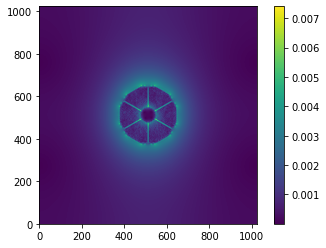

In [5]:
label1 = 'L_CVC_noLT'
psf1_img, psf1_off, psf1_on = add_lighttrap(wf0, label1, **conf)

### Light trap at start of propagation (downstream of VPM, diverging beam)

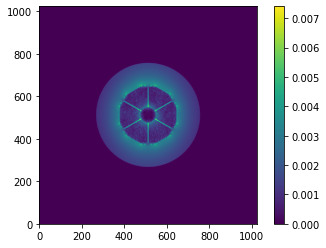

In [6]:
label2 = 'L_CVC_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
psf2_img, psf2_off, psf2_on = add_lighttrap(wf0, label2, **dict(conf, lt_dist_start=lt_dist_start*scaling,
    lt_diam_start=lt_diam_start/conf['diam_ext']*scaling))

### Light trap at end of propagation (upstream of LS, collimated beam)

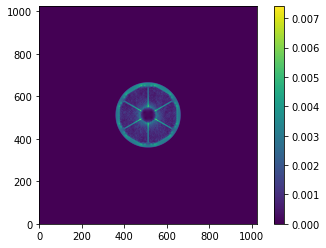

In [7]:
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
psf3_img, psf3_off, psf3_on = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_L*scaling,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']*scaling))

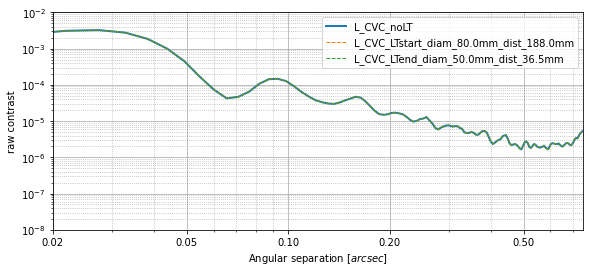

In [8]:
raw_contrast('L_raw_cc', conf['pscale'], psf1_off, [psf1_on, psf2_on, psf3_on], [label1, label2, label3])

# 2. L-band, rescaled to the size of beam inside METIS (diam_nominal_METIS = 45.0e-3 m)

In [9]:
# rescale all length parameters
conf['focal'] /= scaling
conf['pupil_img_size'] /= scaling
conf['diam_nominal'] /= scaling
conf['diam_ext'] /= scaling
conf['diam_int'] /= scaling
conf['spi_width'] /= scaling
conf['seg_width'] /= scaling
conf['seg_gap'] /= scaling
# make sure lyot-stop is not preloaded
conf['ls_mask'] = None
# get off-axis PSF (without SCAO phase screen)
wf0 = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
psf_OFF = heeps.wavefront.propagate_one(deepcopy(wf0), onaxis=False, 
    verbose=True, **conf)
# add phase screen
phase_screens, amp_screens, tiptilts, apo_misaligns, ls_misaligns = heeps.wavefront.load_errors(
    verbose=True, **conf)
wf0 = heeps.wavefront.add_errors(wf0, phase_screen=phase_screens[0], 
    verbose=True, **conf)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Create single off-axis PSF
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.0209, 0.09, 0.0245], ls_misalign=None
   extract PSF on the detector: ndet=293
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)


### no light trap

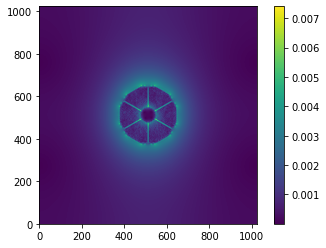

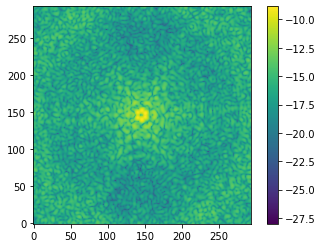

In [10]:
label1 = 'L_CVC_noLT'
psf1_img, psf1_off, psf1_on = add_lighttrap(wf0, label1, **conf, show=True, write=True)
plt.figure();plt.imshow(np.log(psf1_on), origin='lower'); plt.colorbar();

### HCI mode + light trap

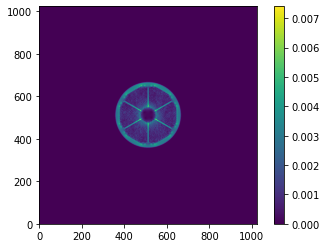

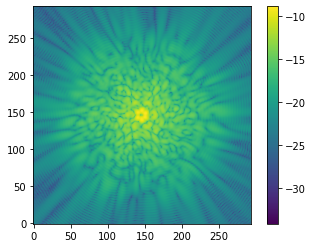

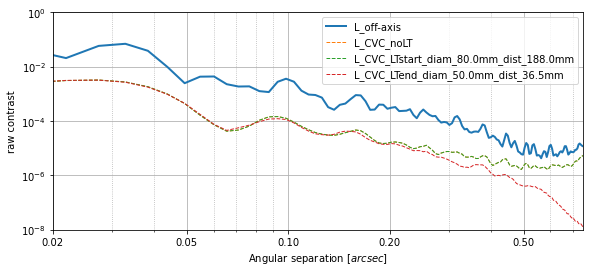

In [11]:
label2 = 'L_CVC_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
psf2_img, psf2_off, psf2_on = add_lighttrap(wf0, label2, **dict(conf, lt_dist_start=lt_dist_start,
    lt_diam_start=lt_diam_start/conf['diam_ext']), show=False)
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
psf3_img, psf3_off, psf3_on = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=True, write=True)
plt.figure();plt.imshow(np.log(psf3_on), origin='lower'); plt.colorbar()
raw_contrast('L_raw_cc_cvc', conf['pscale'], psf1_off, [psf1_off, psf1_on, psf2_on, psf3_on], 
    ['L_off-axis', label1, label2, label3], ymax=1)

### IMG mode + light trap

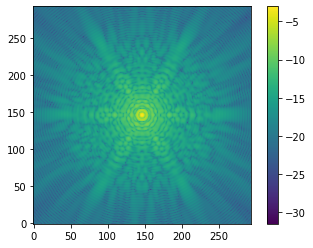

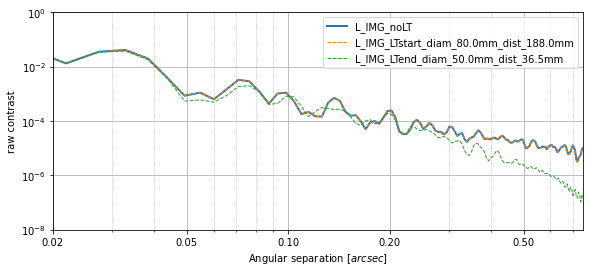

In [12]:
plt.figure();plt.imshow(np.log(psf3_img), origin='lower'); plt.colorbar()
label1_img = 'L_IMG_noLT'
label2_img = 'L_IMG_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
label3_img = 'L_IMG_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
raw_contrast('L_raw_cc_img', conf['pscale'], psf1_img, [psf1_img, psf2_img, psf3_img], 
    [label1_img, label2_img, label3_img], ymax=1)

# explore larger light traps

### with current distance = 36.5mm

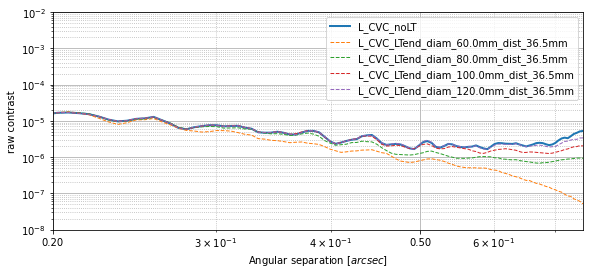

In [13]:
lt_dist_end_L = 36.5e-3
lt_diam_end_L = 60e-3#61e-3
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf3 = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 80e-3#70e-3
label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf4 = add_lighttrap(wf0, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 100e-3#79e-3
label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf5 = add_lighttrap(wf0, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 120e-3#88e-3
label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf6 = add_lighttrap(wf0, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
raw_contrast('L_raw_cc_explore_diam', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6], 
        [label1, label3, label4, label5, label6], xmin=0.2)

### with "optimized" distance = 58mm

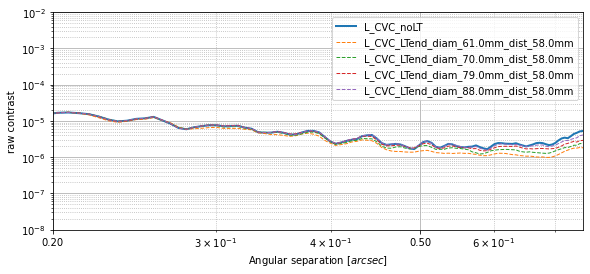

In [14]:
lt_dist_end_L = 58e-3
lt_diam_end_L = 61e-3
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf3 = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 70e-3
label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf4 = add_lighttrap(wf0, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 79e-3#68e-3
label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf5 = add_lighttrap(wf0, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 88e-3#77e-3
label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf6 = add_lighttrap(wf0, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
raw_contrast('L_raw_cc_explore_diam', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6], 
        [label1, label3, label4, label5, label6], xmin=0.2)

# explore longer distances

### with current diameter = 50mm

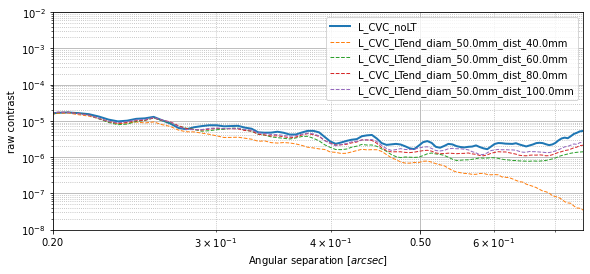

In [15]:
lt_diam_end_L = 50e-3
lt_dist_end_L = 40e-3
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf3 = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_dist_end_L = 60e-3#46e-3
label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf4 = add_lighttrap(wf0, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_dist_end_L = 80e-3#52e-3
label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf5 = add_lighttrap(wf0, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_dist_end_L = 100e-3#58e-3
label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf6 = add_lighttrap(wf0, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
raw_contrast('L_raw_cc_explore_dist', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6], 
        [label1, label3, label4, label5, label6], xmin=0.2)

### with "optimized" diameter = 88mm

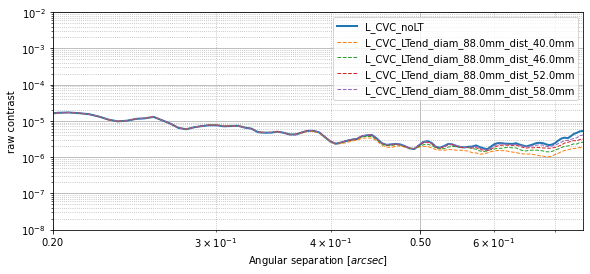

In [16]:
lt_diam_end_L = 88e-3#77e-3#
lt_dist_end_L = 40e-3#36.5e-3
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf3 = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_dist_end_L = 46e-3
label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf4 = add_lighttrap(wf0, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_dist_end_L = 52e-3
label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf5 = add_lighttrap(wf0, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_dist_end_L = 58e-3
label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf6 = add_lighttrap(wf0, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
raw_contrast('L_raw_cc_explore_dist', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6], 
        [label1, label3, label4, label5, label6], xmin=0.2)

# explore combination of diams and distances

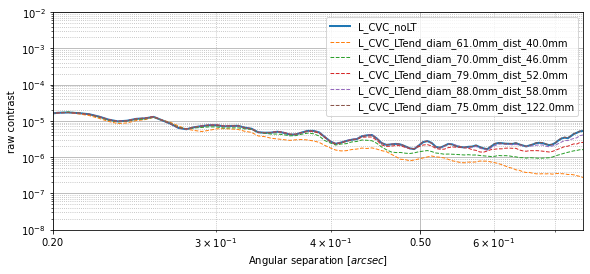

In [17]:
lt_diam_end_L = 75e-3 # LMS: 33e-3/19.9*45
lt_dist_end_L = 122e-3# LMS: 54e-3/19.9*45
label2 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf2 = add_lighttrap(wf0, label2, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 61e-3
lt_dist_end_L = 40e-3
label3 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf3 = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 70e-3
lt_dist_end_L = 46e-3
label4 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf4 = add_lighttrap(wf0, label4, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 79e-3
lt_dist_end_L = 52e-3
label5 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf5 = add_lighttrap(wf0, label5, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
lt_diam_end_L = 88e-3
lt_dist_end_L = 58e-3
label6 = 'L_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_L*1e3, lt_dist_end_L*1e3)
_,_,psf6 = add_lighttrap(wf0, label6, **dict(conf, lt_dist_end=lt_dist_end_L,
    lt_diam_end=lt_diam_end_L/conf['diam_ext']), show=False)
raw_contrast('L_raw_cc_explore_combi', conf['pscale'], psf1_off, [psf1_on, psf3, psf4, psf5, psf6, psf2], 
        [label1, label3, label4, label5, label6, label2], xmin=0.2)

# 2. N band

In [18]:
conf = dict(
    band = 'N2',
    mode = 'CVC',
    f_pupil = 'pupil/ELT_fullM1.fits',
    f_phase = 'wavefront/cfull/cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits',
    nframes = 1,
    hfov = 2.4,#1.3,
    ls_dRext = 0.0268,
    ls_dRint = 0.09,
    ls_dRspi = 0.0357,
)
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
# rescale to size of beam inside METIS
conf['focal'] /= scaling
conf['pupil_img_size'] /= scaling
conf['diam_nominal'] /= scaling
conf['diam_ext'] /= scaling
conf['diam_int'] /= scaling
conf['spi_width'] /= scaling
conf['seg_width'] /= scaling
conf['seg_gap'] /= scaling
# get off-axis PSF (without SCAO phase screen)
wf0 = heeps.pupil.pupil(savefits=True, verbose=True, **conf)
psf_OFF = heeps.wavefront.propagate_one(deepcopy(wf0), onaxis=False, 
    verbose=True, **conf)
# add phase screen
phase_screens, amp_screens, tiptilts, apo_misaligns, ls_misaligns = heeps.wavefront.load_errors(
    verbose=True, **conf)
wf0 = heeps.wavefront.add_errors(wf0, phase_screen=phase_screens[0], 
    verbose=True, **conf)

Simulation config: band=N2, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, diam_norm=1.0838, beam_ratio=0.1072
   npupil=119, pscale=6.7900 mas, lam=1.1330E-05 m
   hfov=2.4 arcsec (-> ndet=707, 37.9 lam/D)

Entrance pupil: loaded from 'ELT_fullM1.fits'
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
Create single off-axis PSF
   apply Lyot stop: circ_ext/int=[False, False], ls_dRext/int/spi=[0.0268, 0.09, 0.0357], ls_misalign=None
   extract PSF on the detector: ndet=707
Load phase screens from 'cube_Cfull_20211007_3600s_300ms_0piston_meters_scao_only_L_285.fits'
   nscreens=1 (nframes=1, nstep=1)


### No light trap

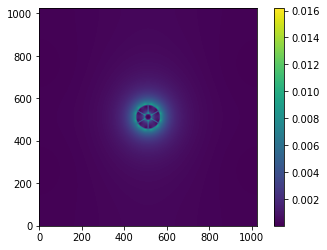

In [19]:
label1 = 'N_CVC_noLT'
_,_,psf1 = add_lighttrap(wf0, label1, **conf)

### Light trap before lens (diverging beam)

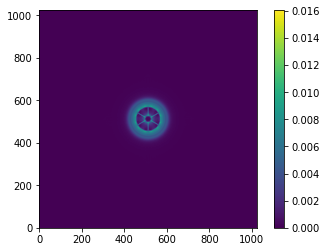

In [20]:
label2 = 'N_CVC_LTstart_diam_%.1fmm_dist_%.1fmm'%(lt_diam_start*1e3, lt_dist_start*1e3)
_,_,psf2 = add_lighttrap(wf0, label2, **dict(conf, lt_dist_start=lt_dist_start,
    lt_diam_start=lt_diam_start/conf['diam_ext']))

### Light trap after lens (collimated beam)

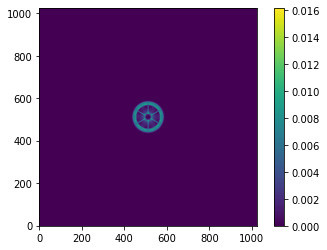

In [21]:
label3 = 'N_CVC_LTend_diam_%.1fmm_dist_%.1fmm'%(lt_diam_end_N*1e3, lt_dist_end_N*1e3)
_,_,psf3 = add_lighttrap(wf0, label3, **dict(conf, lt_dist_end=lt_dist_end_N,
    lt_diam_end=lt_diam_end_N/conf['diam_ext']))

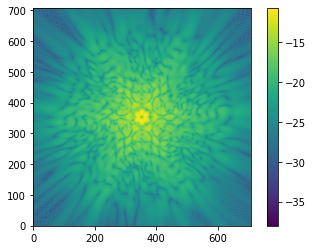

In [22]:
plt.imshow(np.log(psf3), origin='lower'); plt.colorbar()
plt.savefig('N_PSF.png', dpi=300, transparent=True);

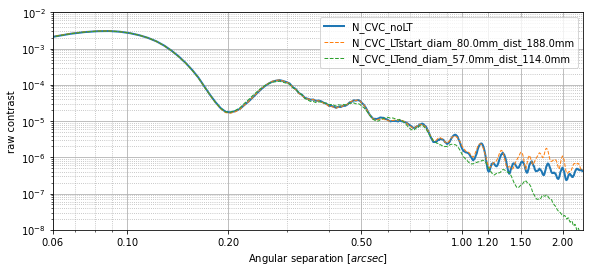

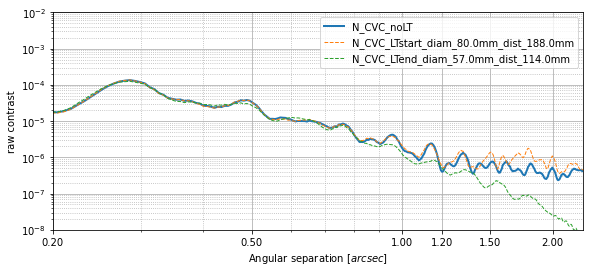

In [23]:
raw_contrast('N_raw_cc', conf['pscale'], psf_OFF, [psf1, psf2, psf3], [label1, label2, label3], band='N')
raw_contrast('N_raw_cc', conf['pscale'], psf_OFF, [psf1, psf2, psf3], [label1, label2, label3], band='N', xmin=0.2)